# Fitting an Orbit
---

In this notebook, we'll go over how to use `jorbit` to fit astrometric observations of a minor planet with an orbit model. We'll start with computing the maximum likelihood solution, but will then go on to show how `jorbit` can be integrated with other sampling libraries to enable MCMC and/or nested sampling routines to estimate the uncertainties on all derived parameters.

Throughout this tutorial, we'll be focusing on observations of a single, massless minor planet. `jorbit` is capable of computing the joint likelihood of a system of multiple particles, some massive and some not, but here we limit ourselves to the simpliest case of one particle.

To start, we collect some necessary imports:

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.data import download_file
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt

Next we'll import the three major components of `jorbit`: the `Observations`, `Particle`, and `System` objects. Most of our work here will consist of creating and manipulating these objects, though users wanting finer control will find `jorbit.engine` useful.

In broad terms, `Oberservations` are associated with `Particle` objects, which are then the building blocks of `System` objects. We'll go through this process below.

In [2]:
from jorbit import Observations, Particle, System

First, we need to generate some fake astrometry data. Here we'll use the `Observations.horizons_astrometry_query` method to automatically query the JPL Horizons ephemeris service, but that's not really important here. Any other method will do, like `astroquery` or manually entering `SkyCoord`s.

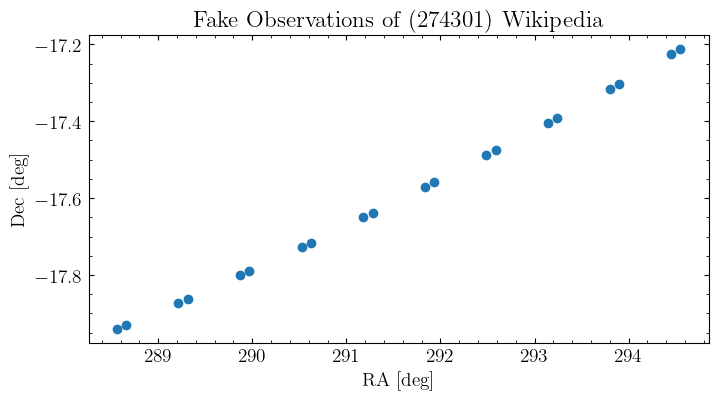

In [3]:
t0 = Time("2023-01-01 07:00")
t1 = Time("2023-01-01 11:00")
early_times = jnp.linspace(t0.jd, t0.jd + 10, 10)
late_times = jnp.linspace(t1.jd, t1.jd + 10, 10)
times = Time(jnp.sort(jnp.concatenate([early_times, late_times])), format='jd')

horizons_query = Horizons(id='274301', location='695@399',
                          epochs=times.jd)
data = horizons_query.ephemerides(extra_precision=True)

observed_coordinates = SkyCoord(data['RA'], data['DEC'])

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(observed_coordinates.ra.deg, observed_coordinates.dec.deg)
ax.set(xlabel="RA [deg]", ylabel="Dec [deg]", title="Fake Observations of (274301) Wikipedia");

We've generated 10 nights of observations, where the object is observed twice each night a few hours apart. Now let's create an `Observations` object:

In [4]:
obs1 = Observations(
    observed_coordinates=observed_coordinates,
    times=times,
    observatory_locations='Kitt Peak',
    astrometric_uncertainties=0.1*u.arcsec,
    verbose_downloading=False,
)

Note how here we manually fed in a `SkyCoord` object, a `Time` object, and astrometric uncertainties in `astropy` units. 

Alternatively, instead of specifying the coordinates, times, observatory locations, and astrometric uncertainties manually, we could instead create and Observations object from a .txt file of observations saved in the standard MPC 80-column format:

In [5]:
# obs2 = Observations(mpc_file='mpc_example_data.txt',
#                    verbose_downloading=True)

This last cell took awhile because of something `Observations` does behind the scenes: for every individual astrometric observation, `jorbit` queries JPL Horizons to get the precise 3D location of the observer at that time. This can take a few minutes if you're combining data from multiple observatories. You can also provide heteroscedastic uncertainties:

In [6]:
# Observations(
#     observed_coordinates=[
#         SkyCoord(0 * u.deg, 0 * u.deg),
#         SkyCoord(10 * u.deg, 10 * u.deg),
#         SkyCoord(20 * u.deg, 20 * u.deg),
#     ],
#     times=Time(["2020-01-01", "2021-01-01", "2022-01-01"]),
#     observatory_locations=["Kitt Peak", "TESS", "JWST"],
#     astrometric_uncertainties=[0.1 * u.arcsec, 20 * u.arcsec, 0.01 * u.arcsec],
#     verbose_downloading=True,
# )

Now let's attach the observations to a `Particle`:

In [7]:
asteroid = Particle(
    elements = {'a':2, 'ecc':0.1, 'inc':0., 'Omega':20, 'omega':10, 'nu':30.},
    time=times[0],
    observations=obs1,
    gm=0,
    name="274301 Wikipedia",
    free_orbit=True,
    free_gm=False,
)

We did not have to include the observations, but we did have to include a guess about its current position/state, even if it's a complete guess. Notice also that we declared that `free_orbit=True`, but that `free_gm=False`; these settings will tell `System` that when constructing a fit, it's allowed to vary the initial orbit on the particle, but not its mass, which is fixed to zero via `gm=0`. All of these settings and more are in the documentation.

Now we can create the last needed object: a `System`.

In [8]:
sim = System(particles=[asteroid])

To get an estimate of the maximum likelihood fit, we run the `maximize_likelihood()` method:

In [9]:
sim.maximimze_likelihood(threshold=1*u.arcsec, 
                         max_attempts=100, verbose=True,
                         method='BFGS')

Compling likelihood and its gradient, if not cached...
Time to evaluate loglike: 4.91 ms
Time to evaluate loglike gradient: 16.26 ms
Failed 1 times(s), will make up to 100 attempts
Failed 2 times(s), will make up to 100 attempts
Failed 3 times(s), will make up to 100 attempts
Failed 4 times(s), will make up to 100 attempts
Failed 5 times(s), will make up to 100 attempts
Failed 6 times(s), will make up to 100 attempts
Failed 7 times(s), will make up to 100 attempts
Failed 8 times(s), will make up to 100 attempts
Failed 9 times(s), will make up to 100 attempts
Failed 10 times(s), will make up to 100 attempts


{'Status': 'Success',
 'Observation Residuals': {'274301 Wikipedia': {'Residuals (arcsec)': Array([8.65058853e-07, 9.24480036e-07, 5.22006208e-07, 1.19068521e-06,
          1.99038849e-06, 1.73250806e-06, 1.63258772e-06, 1.36714444e-06,
          1.37509951e-06, 1.51962621e-06, 6.53394712e-07, 1.28871101e-06,
          4.70672199e-07, 1.03794692e-06, 1.53596822e-06, 1.88476094e-06,
          1.31424072e-06, 2.21663237e-06, 1.71941832e-06, 1.12270572e-06],      dtype=float64),
   'Observation Times (JD)': Array([2459945.79246741, 2459945.95913407, 2459946.90357852,
          2459947.07024518, 2459948.01468963, 2459948.1813563 ,
          2459949.12580074, 2459949.29246741, 2459950.23691185,
          2459950.40357852, 2459951.34802296, 2459951.51468963,
          2459952.45913408, 2459952.62580074, 2459953.57024519,
          2459953.73691185, 2459954.6813563 , 2459954.84802296,
          2459955.79246741, 2459955.95913408], dtype=float64)}}}

In [11]:
sim.particles[0]

Particle: 274301 Wikipedia.
Current state:
--------------
 [ 0.73627287 -1.85355065 -0.55116229] AU
 [0.01150769 0.00511472 0.00161759] AU/day
 2459945.792467406 JD

Current Elements:
-----------------
{'a': Array([2.38093225], dtype=float64
'ecc': Array([0.14645738], dtype=float64
'nu': Array([327.98804539], dtype=float64
'inc': Array([6.73266365], dtype=float64
'Omega': Array([183.35304136], dtype=float64
'omega': Array([139.75996238], dtype=float64)}

In [17]:
# obs = Observations(
#     mpc_file="mpc_example_data.txt",
#     verbose_downloading=True,
# )

asteroid = Particle(
    elements={"a": 2, "ecc": 0.1, "inc": 0.0, "Omega": 20, "omega": 10, "nu": 30.0},
    time=float(obs.times[0]),
    observations=obs,
    gm=0,
    name="274301 Wikipedia",
    free_orbit=True,
    free_gm=False,
)

sim = System(particles=[asteroid])

sim.maximimze_likelihood(threshold=3 * u.arcsec, max_attempts=100, verbose=True)

Compling likelihood and its gradient, if not cached...
Time to evaluate loglike: 133.61 ms
Time to evaluate loglike gradient: 547.93 ms
Failed 1 times(s), will make up to 100 attempts
Failed 2 times(s), will make up to 100 attempts
Failed 3 times(s), will make up to 100 attempts
Failed 4 times(s), will make up to 100 attempts
Failed 5 times(s), will make up to 100 attempts
Failed 6 times(s), will make up to 100 attempts
Failed 7 times(s), will make up to 100 attempts
Failed 8 times(s), will make up to 100 attempts
Failed 9 times(s), will make up to 100 attempts
Failed 10 times(s), will make up to 100 attempts
Failed 11 times(s), will make up to 100 attempts
Failed 12 times(s), will make up to 100 attempts
Failed 13 times(s), will make up to 100 attempts
Failed 14 times(s), will make up to 100 attempts
Failed 15 times(s), will make up to 100 attempts
Failed 16 times(s), will make up to 100 attempts
Failed 17 times(s), will make up to 100 attempts
Failed 18 times(s), will make up to 100 

KeyboardInterrupt: 

Array([2459945.79246741, 2459945.95913407, 2459946.90357852,
       2459947.07024518, 2459948.01468963, 2459948.1813563 ,
       2459949.12580074, 2459949.29246741, 2459950.23691185,
       2459950.40357852, 2459951.34802296, 2459951.51468963,
       2459952.45913408, 2459952.62580074, 2459953.57024519,
       2459953.73691185, 2459954.6813563 , 2459954.84802296,
       2459955.79246741, 2459955.95913408], dtype=float64)